In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [ ]:
!wget "https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip"
!unzip "/content/rockpaperscissors.zip"

In [3]:
os.listdir("/content/rockpaperscissors")

['paper', 'README_rpc-cv-images.txt', 'rock', 'rps-cv-images', 'scissors']

In [4]:
os.listdir("/content/rockpaperscissors/rps-cv-images")

['paper', 'README_rpc-cv-images.txt', 'rock', 'scissors']

In [5]:
base_dir = "/content/rockpaperscissors/rps-cv-images"

train_ds = image_dataset_from_directory(
    directory=base_dir,
    image_size=(150, 150),
    validation_split=0.4,
    subset='training',
    batch_size=32,
    label_mode='categorical',
    seed=1234
)

Found 2188 files belonging to 3 classes.
Using 1313 files for training.


In [6]:
validation_ds = image_dataset_from_directory(
    directory=base_dir,
    image_size=(150, 150),
    validation_split=0.4,
    subset='validation',
    batch_size=32,
    label_mode='categorical',
    seed=1234
)

Found 2188 files belonging to 3 classes.
Using 875 files for validation.


In [7]:
class_names = train_ds.class_names

In [8]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 150, 150, 3)
(32, 3)


In [9]:
image_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.2)
], name='image_augmentation')

In [10]:
train_ds = train_ds.map(
    lambda x, y: (image_augmentation(x), y)
)

In [11]:
validation_ds = validation_ds.map(
    lambda x, y: (image_augmentation(x), y)
)

In [12]:
input_layer = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(16, 3, activation=tf.nn.relu)(input_layer)
x = tf.keras.layers.MaxPool2D(2, 2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu)(x)
x = tf.keras.layers.MaxPool2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(x)
output_layer = tf.keras.layers.Dense(units=3, activation=tf.nn.softmax)(x)


sec_cnn_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [13]:
sec_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
filepath = "/content/model_save"

class MainCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.88 and logs.get('val_accuracy') >= 0.90:
      self.model.stop_training = True

callbacks = MainCallbacks()

In [15]:
history = sec_cnn_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs = 15,
    callbacks=[callbacks],
    verbose=2
)

Epoch 1/15
42/42 - 16s - loss: 1.1435 - accuracy: 0.4798 - val_loss: 0.8962 - val_accuracy: 0.5520 - 16s/epoch - 388ms/step
Epoch 2/15
42/42 - 8s - loss: 0.7333 - accuracy: 0.7014 - val_loss: 0.6751 - val_accuracy: 0.7257 - 8s/epoch - 201ms/step
Epoch 3/15
42/42 - 8s - loss: 0.5645 - accuracy: 0.7867 - val_loss: 0.5263 - val_accuracy: 0.7806 - 8s/epoch - 184ms/step
Epoch 4/15
42/42 - 8s - loss: 0.4948 - accuracy: 0.8142 - val_loss: 0.6069 - val_accuracy: 0.7543 - 8s/epoch - 183ms/step
Epoch 5/15
42/42 - 8s - loss: 0.4275 - accuracy: 0.8408 - val_loss: 0.4245 - val_accuracy: 0.8457 - 8s/epoch - 182ms/step
Epoch 6/15
42/42 - 8s - loss: 0.3675 - accuracy: 0.8675 - val_loss: 0.3295 - val_accuracy: 0.8766 - 8s/epoch - 185ms/step
Epoch 7/15
42/42 - 8s - loss: 0.3382 - accuracy: 0.8759 - val_loss: 0.3393 - val_accuracy: 0.8800 - 8s/epoch - 185ms/step
Epoch 8/15
42/42 - 8s - loss: 0.3268 - accuracy: 0.8736 - val_loss: 0.2557 - val_accuracy: 0.9097 - 8s/epoch - 185ms/step
Epoch 9/15
42/42 - 8s 

In [16]:
train = sec_cnn_model.evaluate(train_ds, verbose=0)[-1]
valid = sec_cnn_model.evaluate(validation_ds, verbose=0)[-1]

print(f"train : {train}, test : {valid}")

train : 0.9238385558128357, test : 0.8994285464286804


In [ ]:
!wget "https://raw.githubusercontent.com/Primezane/Basic/main/History.py"

from History import History

model_plot = History(history)

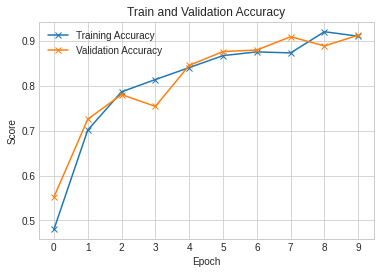

In [18]:
model_plot.acc_plot()

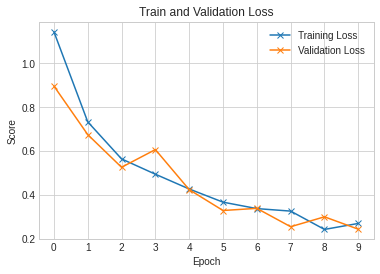

In [19]:
model_plot.loss_plot()

In [20]:
sec_cnn_model.save("rps_cnn.h5")

!mkdir "rps_cnn_model"

tf.saved_model.save(sec_cnn_model, "/content/rps_cnn_model")

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/rps_cnn_model")
tflite_model = converter.convert()

In [22]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

!mkdir tf_lite
!mv model.tflite /content/tf_lite

In [23]:
!ls -l "/content/tf_lite"

total 20764
-rw-r--r-- 1 root root 21259240 Jan 26 06:26 model.tflite


In [26]:
!ls -l "/content/rps_cnn_model"

total 140
drwxr-xr-x 2 root root   4096 Jan 26 06:26 assets
-rw-r--r-- 1 root root 131707 Jan 26 06:26 saved_model.pb
drwxr-xr-x 2 root root   4096 Jan 26 06:26 variables
